# What can we say about the temporal statistics of repeater bursts?
## Do these properties reflect the larger FRB population?

In [73]:
%matplotlib inline

In [93]:
import numpy as np
import pylab as pl
from astropy.stats import LombScargle
from astropy.time import Time
import astropy.units as u
import astropy.coordinates as coord
from scipy.stats import poisson

# for plotting lots of points
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [75]:
# program 15B-378
# 10 hours no detections
#obstimes_L = """"""

# programs 16A-459 and 16A-496
# 9 detections
obstimes_S = """
16-Apr-25 23:21:39, 16-Apr-26 03:21:00
16-Apr-26 23:14:31, 16-Apr-27 01:14:11
16-Apr-27 23:26:09, 16-Apr-28 01:25:50
16-Apr-28 22:41:31, 16-Apr-29 00:41:11
16-Apr-29 22:37:34, 16-Apr-30 00:37:14
16-Apr-30 19:14:46, 16-Apr-30 20:14:35
16-May-01 18:08:21, 16-May-01 19:08:10
16-May-02 23:14:18, 16-May-03 00:14:07
16-May-03 22:53:26, 16-May-03 23:53:15
16-May-04 22:50:30, 16-May-04 23:50:19
16-May-06 18:25:12, 16-May-06 19:25:01
16-May-07 19:34:13, 16-May-07 20:34:03
16-May-08 19:30:20, 16-May-08 20:30:10
16-May-13 17:12:48, 16-May-13 19:27:25
16-May-14 17:14:11, 16-May-14 19:28:48
16-May-15 17:15:26, 16-May-15 19:30:03
16-May-16 16:59:52, 16-May-16 19:14:29
16-May-20 16:45:46, 16-May-20 19:00:23
16-May-21 16:44:06, 16-May-21 18:58:44
16-May-22 16:43:53, 16-May-22 18:58:30
16-May-23 16:44:11, 16-May-23 18:58:48
16-May-27 16:29:34, 16-May-27 18:44:11
16-Aug-23 17:26:28, 16-Aug-23 18:20:18
16-Sep-02 15:52:17, 16-Sep-02 16:46:08
16-Sep-07 10:14:50, 16-Sep-07 12:14:29
16-Sep-08 10:14:40, 16-Sep-08 12:14:19
16-Sep-10 09:59:36, 16-Sep-10 11:59:15
16-Sep-11 09:59:49, 16-Sep-11 11:59:29
16-Sep-12 09:15:19, 16-Sep-12 11:14:58
16-Sep-13 09:23:59, 16-Sep-13 11:23:39
16-Sep-14 09:20:23, 16-Sep-14 11:20:03
16-Sep-15 09:16:29, 16-Sep-15 11:16:09
16-Sep-16 09:11:23, 16-Sep-16 11:11:03
16-Sep-17 08:59:20, 16-Sep-17 10:59:00
16-Sep-18 08:59:27, 16-Sep-18 10:59:07
16-Sep-19 08:44:32, 16-Sep-19 10:44:12
16-Sep-20 08:44:33, 16-Sep-20 10:44:13
"""

# end of 16A-496
# no detections
obstimes_C = """
16-Sep-20 17:19:03, 16-Sep-20 19:18:42
16-Sep-21 09:13:57, 16-Sep-21 11:13:36
16-Sep-22 09:12:24, 16-Sep-22 11:12:04
"""

In [76]:
minmjd = 57620
ranges = []
for tr in obstimes_S.split('\n')[1:-1]:
    start, stop = tr.split(', ')
    start = start.replace('Apr', '04').replace('May', '05').replace('Aug', '08').replace('Sep', '09').replace('16-', '2016-')
    stop = stop.replace('Apr', '04').replace('May', '05').replace('Aug', '08').replace('Sep', '09').replace('16-', '2016-')
    starttime = Time(start, format='iso', scale='utc').mjd
    stoptime = Time(stop, format='iso', scale='utc').mjd
    if starttime > minmjd:
        ranges.append((starttime, stoptime))
    
tot = 0
start, stop = ranges[0]
sampling = 24*3600*100 # per day
times = np.linspace(start, stop, (stop-start)*sampling)
for rr in ranges[1:]:
    start, stop = rr
    tot += 24*(stop - start)
    times = np.concatenate( (times, np.linspace(start, stop, (stop-start)*sampling)), axis=0)

print('{0} hours in {1} observations'.format(tot, len(ranges)))
print('{0} time bins'.format(len(times)))

26.8241666669 hours in 15 observations
9979691 time bins


In [102]:
vla = coord.EarthLocation(-107.5, 34., 2000)

eventtimes = Time([57623.74402686, 57633.67986367, 57633.695159375, 57638.49937435, 57643.45730263, 
                   57645.42958602, 57646.4660065, 57648.4369149, 57649.45175697], 
                  format='mjd', location=vla, scale='utc') # topocentric, top of band

# TODO: dm-correct and barycenter vla bursts
#et_vla = 

et_sp = Time([56233.282837008, 57159.737600835, 57159.744223619, 57175.693143232, 57175.699727826,
         57175.742576706, 57175.742839344, 57175.743510388, 57175.745665832, 57175.747624851,
         57175.748287265], scale='tcb', format='mjd') # barycentered, infinite freq

et_sc = Time([57339.356046005567, 57345.447691250090, 57345.452487925162, 57345.457595303807, 
         57345.462413106565, 57364.204632665605], scale='tcb', format='mjd')  # barycentered, infinite freq

In [90]:
values0 = np.zeros(len(times), dtype=bool)
for eventtime in eventtimes:
    bn = np.where(times > eventtime)[0]
    if len(bn) and bn[0] > 0:
        print(eventtime, bn[0])
        values0[bn[0]] = 1

(57623.74402686, 149592)
(57633.67986367, 483322)
(57638.49937435, 1271693)
(57643.45730263, 4136993)
(57645.42958602, 5303021)
(57646.4660065, 6359092)
(57648.4369149, 7646639)
(57649.45175697, 8492173)


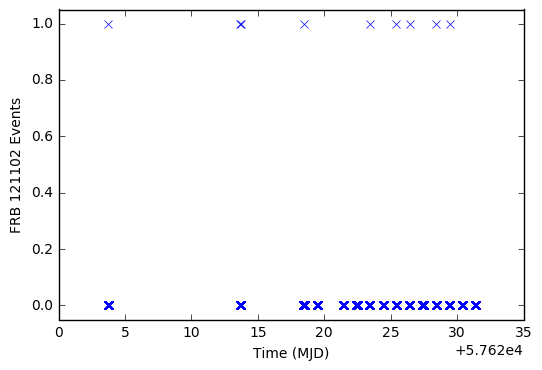

In [85]:
pl.plot(times, values0, 'x')
#pl.plot(times[np.argwhere(times > 57600)], values0[np.argwhere(times > 57600)], '.')
pl.ylim(-0.05, 1.05)
pl.xlabel('Time (MJD)')
pl.ylabel('FRB 121102 Events')

## Lomb-Scargle analysis

In [86]:
def runls(times, values, fr=(), verbose=False):
    ls = LombScargle(times, values)
    if len(fr):
        f0, f1 = fr
        freq, power = ls.autopower(minimum_frequency=f0, maximum_frequency=f1)
    else:
        freq, power = ls.autopower()
        
    if verbose:
        print('{0} bins for periods from {1}-{2} s'.format(len(freq), 24*3600./freq.max(), 24*3600./freq.min()))
        
    return freq, power, ls

12474297 bins for periods from 0.864000054544-8.64 s


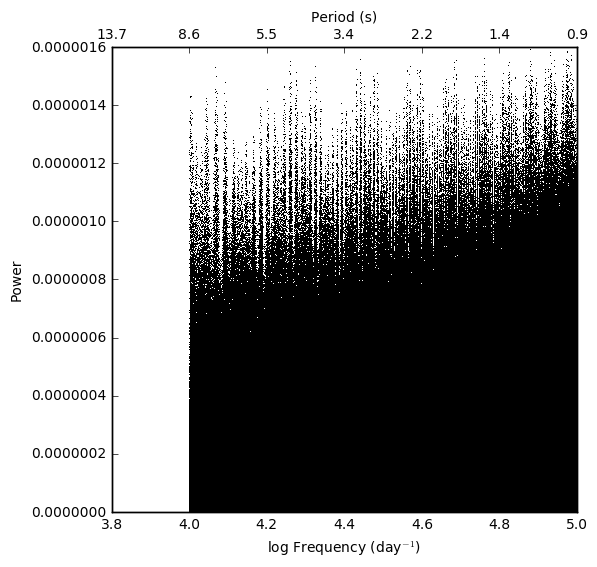

In [91]:
fr = (1e4, 1e5)
freq0, power0, ls = runls(times, values0, fr=fr, verbose=True)

fig = pl.figure(figsize=(6,6))
ax = fig.add_subplot(111)
pl.plot(np.log10(freq0), power0, 'k,')
xts = ax.get_xticks()
pl.ylabel('Power')
pl.xlabel('log Frequency (day$^{-1}$)')
ax2 = ax.twiny()
pl.plot(np.log10(freq0), power0, 'k,')
pl.xlabel('Period (s)')
xtb = ax.get_xticks().tolist()
xtt = [np.round(24*3600./10**xt, 1) for xt in xtb]
ax2.set_xticklabels(xtt)#, rotation=45)

In [ ]:
fig = pl.figure(figsize=(6,6))
ax = fig.add_subplot(111)
best_frequency = freq0[np.argmax(power0)]
print('Peak power frequency: {0} s'.format(24*3600./best_frequency))
t_fit = np.linspace(0, 1)
y_fit = ls.model(t_fit, best_frequency)
phase = (times * best_frequency) % 1
pl.plot(phase, values0, '.')
pl.ylim(-0.1, 1.1) 
pl.show()

## simulate Lomb-Scargle to find effect of observing cadence

In [ ]:
ntr = 100
powers = []
for trial in range(ntr):
    print('trial {0}'.format(trial))
    values = np.zeros(len(times), dtype=bool)
#    ets = np.random.choice(times[np.where(times > 57600)], size=9, replace=False)  # only last campaign
    ets = np.random.choice(times, size=9, replace=False)  # all times
    for et in ets:
        etind = np.where(times >= et)[0][0]
        values[etind] = 1
        
#    pl.plot(times, values, '.')
#    pl.ylim(-0.1, 1.1)
    freq, power, lsn = runls(times, values, fr=fr)
#    plotls(freq, power)
    powers.append(power)
    
powers = np.array(powers)

In [ ]:
bound = 0.05

powsort = np.sort(powers, axis=0)
powh = powsort[int((1-bound)*ntr)-1]

fig = pl.figure(figsize=(6,6))
ax = fig.add_subplot(111)
pl.plot(np.log10(freq0), power0, 'k.')
pl.plot(np.log10(freq0), powh, 'c')
xts = ax.get_xticks()
pl.ylabel('Power')
pl.xlabel('log Frequency (day$^{-1}$)')
ax2 = ax.twiny()
pl.plot(np.log10(freq0), power0, 'k.')
pl.plot(np.log10(freq0), powh, 'c')
pl.xlabel('Period (s)')
xtb = ax.get_xticks().tolist()
xtt = [np.round(24*3600./10**xt, 1) for xt in xtb]
ax2.set_xticklabels(xtt)#, rotation=45)

## AO L-band burst times (miracle obs)

In [48]:
per = 20.1533e-3/(24*3600)  # assumed period in email in seconds
ao_diff = np.array([82005.81250, 11447.33008, 8231.58301, 12424.39551, 1106.53979, 7071.23340, 12601.21582, 
                    514.99109, 2433.00342, 33937.77734, 12276.32031, 18964.84961, 25424.97461, 47097.52734, 
                    8049.33984, 37107.89453])*per

ao_eventtimes = ao_diff.cumsum()

In [49]:
sampling = 24*3600*100 # per second
start = ao_eventtimes[0] - 10./(60*24) # starts 10 min before first
stop = ao_eventtimes[-1] + 10./(60*24) # stops 10 min after last
ao_times = np.linspace(start, stop, (stop-start)*sampling)

In [50]:
ao_values = np.zeros(len(ao_times), dtype=bool)
for eventtime in ao_eventtimes:
    bn = np.where(ao_times > eventtime)[0]
    if len(bn) and bn[0] > 0:
        print(eventtime, bn[0])
        ao_values[bn[0]] = 1

(0.019128330336299189, 60000)
(0.021798486323582337, 83071)
(0.02371855069714059, 99660)
(0.026616612850285069, 124699)
(0.026874719659889319, 126929)
(0.0285241257719289, 141180)
(0.031463432285646561, 166575)
(0.031583556937661572, 167613)
(0.032151069065257477, 172517)
(0.040067252028986901, 240912)
(0.042930774784814711, 265653)
(0.047354435706634307, 303874)
(0.053284958169686543, 355113)
(0.064270728976876607, 450030)
(0.066148284076384387, 466252)
(0.074803915220266901, 541037)


In [71]:
fr = (9e4, 2e5)
ao_freq, ao_power, ls = runls(ao_times, ao_values, fr=fr, verbose=True)

38261 bins for periods from 0.432002860221-0.96 s


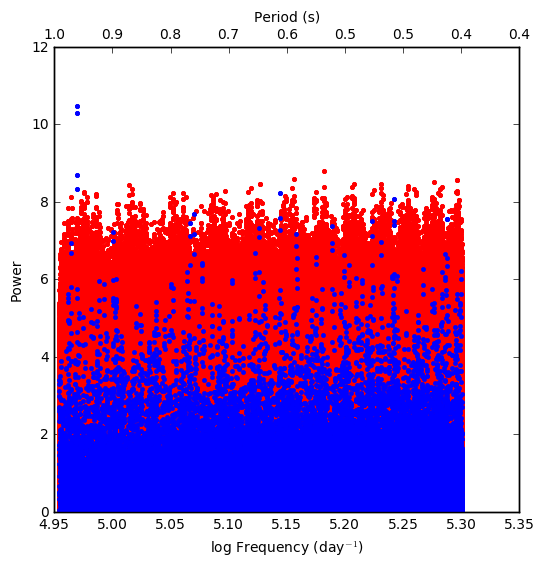

In [72]:
fig = pl.figure(figsize=(6,6))
ax = fig.add_subplot(111)
pl.plot(np.log10(ao_freq), ao_power/ao_power.mean(), 'b.')
pl.plot(np.log10(freq0), power0/power0.mean(), 'r.')
xts = ax.get_xticks()
pl.ylabel('Power')
pl.xlabel('log Frequency (day$^{-1}$)')
ax2 = ax.twiny()
pl.plot(np.log10(freq0), power0/power0.mean(), 'r.')
pl.plot(np.log10(ao_freq), ao_power/ao_power.mean(), 'b.')
pl.xlabel('Period (s)')
xtb = ax.get_xticks().tolist()
xtt = [np.round(24*3600./10**xt, 1) for xt in xtb]
ax2.set_xticklabels(xtt)#, rotation=45)

## Period search

In [ ]:
# find high frequencies in l-s analysis
high = np.where(power0 > 0.9*power0.max())
print(len(high[0]), len(freq0))
print(24*3600./freq0[high])

In [ ]:
# calculate all differential arrival times
delta = [(i,j, eventtimes[j] - eventtimes[i]) for i in range(len(eventtimes)) for j in range(i+1, len(eventtimes))]
delta = np.array(delta)
print(delta)

In [ ]:
cnts = []
edgs = []
for hh in high[0]:
    rots = np.mod(hh*delta[:,2], 1)
    cnt, edg = pl.histogram(rots, bins=np.linspace(0,1,30))
    cnts.append(cnt)
    edgs.append(edg)

cntmax = max([cnt.max() for cnt in cnts])
print(cntmax)
for i in range(len(high[0])):
    if cnts[i].max() >= cntmax:
        rots = np.mod(high[0][i]*delta[:,2], 1)
        print(high[0][i], 24*3600./freq0[high[0][i]])
        diffs = [(delta[j,0], delta[j,1], rots[j]) for j in range(len(rots))]
        for diff in diffs:
            print(diff)
        pl.plot(edgs[i][:-1], cnts[i], '.')

## Rate

In [ ]:
# is the rate dropping in time?
sel = np.where((times > 57600) & (times < 57635))
print(values0[sel].mean()*3600)
sel = np.where((times > 57635) & (times < 57660))
print(values0[sel].mean()*3600)

In [ ]:
t0 = 57623.
rate = lambda t, a, b: a+b*(t-t0)
rprod = lambda t, v, a, b: np.prod(poisson.pmf(v, np.maximum(rate(t, a, b), 0.)))

In [ ]:
ar = np.linspace(1e-5, 7.5e-4, 70)
br = np.linspace(-2.8e-5, 0.5e-5, 50)
sel = np.where((times > t0))
probs = np.zeros(shape=(len(ar), len(br)))

In [ ]:
for i in range(len(ar)):
    for j in range(len(br)):
        probs[i,j] = rprod(times[sel], values0[sel], ar[i], br[j])
probs = np.ma.masked_invalid(probs)

In [ ]:
fig = pl.figure(figsize=(7,7))
ax = fig.add_subplot(111)
pl.imshow(probs/probs.max(), interpolation='nearest', aspect='auto', origin='bottom', cmap='magma',
          extent=(br[0], br[-1], ar[0], ar[-1]))
X, Y = np.meshgrid(br, ar)
pl.contour(X, Y, probs/probs.max(), [0.05, 0.1, 0.2], colors='w')
#pl.contour(probs/probs.max(), [0.05])
pl.xlabel('Rate change (s$^{-1}$ day$^{-1}$)', fontsize=14)
pl.ylabel('Rate (s$^{-1}$)', fontsize=14)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=2, color='w')
ax.yaxis.set_tick_params(width=2, color='w')
#pl.colorbar()

bm, am = np.where(probs == probs.max())
print(am[0], bm[0], probs[bm, am].data[0])